## Libraries

In [2]:
!pip install transformers==4.36.0
!pip install --upgrade gensim
!pip install textacy
!pip install contractions

In [20]:
#!pip install keras==2.15.0
#import os
#os.environ['TF_USE_LEGACY_KERAS'] = '1'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 91.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2


In [1]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Base
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os

    # Model
    import tensorflow as tf
    import transformers
    #import keras
    #import tensorflow_hub as hub
    from tensorflow.keras import layers
    from tensorflow import keras
    from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
    from sklearn.metrics import make_scorer, accuracy_score
    from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
    from sklearn.svm import SVC
    from gensim.models import Word2Vec

    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Dropout, LSTM, GRU, Bidirectional
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.losses import SparseCategoricalCrossentropy
    from tensorflow.keras.optimizers import Adam

    from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

    from sklearn.model_selection import train_test_split
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
    from sklearn.preprocessing import LabelEncoder

    # Text Pre-Processing
    import re
    import nltk
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    from nltk.stem import WordNetLemmatizer
    import textacy
    import textacy.preprocessing as tprep
    import spacy
    import contractions

    # Download required NLTK resources if not already downloaded
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

# Configuration
#import warnings
#warnings.filterwarnings('ignore')
#pd.set_option('display.max_columns', None)
#warnings.simplefilter('ignore')
#pd.options.mode.chained_assignment = None # to supress dataframe warning

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sahilkhanna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sahilkhanna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sahilkhanna/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [31]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

#print("Keras version " + tf.keras.__version__)

import keras
print("Keras version " + keras.__version__)

#import tensorflow_hub as hub

print("Transformers version " + transformers.__version__)

Tensorflow version 2.15.0
Keras version 2.15.0
Transformers version 4.36.0


## Loading Text Source

* This text source is a IMDB Movie Review [Dataset](https://www.kaggle.com/datasets/columbine/imdb-dataset-sentiment-analysis-in-csv-format) transform into CSV files

In [7]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
valid = pd.read_csv('Valid.csv')
df = pd.read_csv('IMDB_Dataset.csv')

In [8]:
train.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [9]:
print("############### Train ###############\n")
print(train.info())
print("\n############### Test ###############\n")
print(test.info())

############### Train ###############

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB
None

############### Test ###############

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   label   5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.2+ KB
None


In [10]:
print("\n############### Entire Dataset ###############\n")
print(df.info())


############### Entire Dataset ###############

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    50000 non-null  object
 1   label   50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB
None


In [ ]:
# show how many tokens the text source has?
whole_text = " ".join(df["text"].to_list())
print("Number of tokens:", len(nltk.word_tokenize(whole_text)))

Number of tokens: 13974091


## Processing Text

In [11]:
# Functions to clean and normalize the text
def normalize(text):
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    text = tprep.replace.phone_numbers(text)
    text = tprep.replace.urls(text)
    text = tprep.replace.emails(text)
    text = tprep.replace.user_handles(text)
    text = tprep.replace.emojis(text)
    text = text.lower()
    return text

def preprocess_text(text):
    # Remove HTML tags
    text = re.sub('<[^>]*>', '', text)

    # Handle contractions (optional but useful)
    text = contractions.fix(text)  # If using contractions module

    # Remove non-alphabetic characters but keep digits
    text = re.sub('[^a-zA-Z0-9]', ' ', text).lower()

    # Tokenize the text
    words = word_tokenize(text)

    # Remove punctuation
    words = [word for word in words if word.isalnum()]  # Retains alphanumeric tokens

    # Remove stopwords but keep negations like "not", "no", "never"
    stop_words = set(stopwords.words('english')) - {'not', 'no', 'never'}
    words = [word for word in words if word not in stop_words]

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Remove extra whitespaces
    return ' '.join(words).strip()

In [12]:
%%time
train['processed_text'] = train['text'].apply(normalize)
test['processed_text'] = test['text'].apply(normalize)
valid['processed_text'] = valid['text'].apply(normalize)
df['processed_text'] = df['text'].apply(normalize)

CPU times: user 1min 44s, sys: 377 ms, total: 1min 44s
Wall time: 1min 44s


In [13]:
df.head()

,text,label,processed_text
0,I grew up (b. 1965) watching and loving the Th...,0,i grew up (b. 1965) watching and loving the th...
1,"When I put this movie in my DVD player, and sa...",0,"when i put this movie in my dvd player, and sa..."
2,Why do people who do not know what a particula...,0,why do people who do not know what a particula...
3,Even though I have great interest in Biblical ...,0,even though i have great interest in biblical ...
4,Im a die hard Dads Army fan and nothing will e...,1,im a die hard dads army fan and nothing will e...


In [14]:
%%time
train['processed_text'] = train['processed_text'].apply(preprocess_text)
test['processed_text'] = test['processed_text'].apply(preprocess_text)
valid['processed_text'] = valid['processed_text'].apply(preprocess_text)
df['processed_text'] = df['processed_text'].apply(preprocess_text)

CPU times: user 2min 18s, sys: 3.1 s, total: 2min 22s
Wall time: 2min 21s


In [15]:
df.head()

,text,label,processed_text
0,I grew up (b. 1965) watching and loving the Th...,0,grew b 1965 watching loving thunderbird mate s...
1,"When I put this movie in my DVD player, and sa...",0,put movie dvd player sat coke chip expectation...
2,Why do people who do not know what a particula...,0,people not know particular time past like feel...
3,Even though I have great interest in Biblical ...,0,even though great interest biblical movie bore...
4,Im a die hard Dads Army fan and nothing will e...,1,die hard dad army fan nothing ever change got ...


In [ ]:
# show how many tokens the text source has?
whole_text = " ".join(df["processed_text"].to_list())
print("Number of tokens:", len(nltk.word_tokenize(whole_text)))

Number of tokens: 6137297


## Using BOW, Tf-IDF & Word2Vec with SVM

In [ ]:
def train_svm_with_representations(train_data, test_data, representation):
    if representation == 'bow':
        vectorizer = CountVectorizer()
    elif representation == 'tfidf':
        vectorizer = TfidfVectorizer()
    else:
        raise ValueError("Invalid representation. Choose 'bow' or 'tfidf'.")

    X_train = vectorizer.fit_transform(train_data)
    X_test = vectorizer.transform(test_data)

    clf = SVC()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return y_pred

def get_word2vec_embeddings(data):
    tokenized_sentences = [sentence.split() for sentence in data]
    model = Word2Vec(tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)
    embeddings = np.array([np.mean([model.wv[word] for word in sentence], axis=0) for sentence in tokenized_sentences])

    return embeddings

def train_svm_with_word2vec(train_data, test_data):
    X_train = get_word2vec_embeddings(train_data)
    X_test = get_word2vec_embeddings(test_data)

    clf = SVC()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return y_pred

In [ ]:
X_train = train['processed_text']
y_train = train['label']
X_test = test['processed_text']
y_test = test['label']

### Bag of Words

In [ ]:
%%time
y_pred_bow = train_svm_with_representations(X_train, X_test, 'bow')
accuracy_bow = accuracy_score(y_test, y_pred_bow)
print(accuracy_bow)

0.8812
CPU times: user 36min 5s, sys: 901 ms, total: 36min 6s
Wall time: 36min 2s


### TF-IDF

In [ ]:
%%time
y_pred_tfidf = train_svm_with_representations(X_train, X_test, 'tfidf')
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
print(accuracy_tfidf)

0.9026
CPU times: user 46min 56s, sys: 759 ms, total: 46min 57s
Wall time: 46min 51s


### Word2Vec

In [ ]:
%%time
y_pred_word2vec = train_svm_with_word2vec(X_train, X_test)
accuracy_word2vec = accuracy_score(y_test, y_pred_word2vec)
print(accuracy_word2vec)

0.4992
CPU times: user 2min 24s, sys: 408 ms, total: 2min 24s
Wall time: 1min 34s


In [ ]:
import gensim.downloader as api

def get_google_word2vec_embeddings(data):
    # Load the Google News Word2Vec model
    model = api.load("word2vec-google-news-300")

    tokenized_sentences = [sentence.split() for sentence in data]
    embeddings = []

    for sentence in tokenized_sentences:
        sentence_embeddings = []
        for word in sentence:
            if word in model:
                sentence_embeddings.append(model[word])
        if sentence_embeddings:
            embeddings.append(np.mean(sentence_embeddings, axis=0))
        else:
            embeddings.append(np.zeros(300))

    return np.array(embeddings)

In [ ]:
def train_svm_with_google_word2vec(train_data, test_data):
    X_train = get_google_word2vec_embeddings(train_data)
    X_test = get_google_word2vec_embeddings(test_data)

    clf = SVC()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return y_pred

In [ ]:
# Google News Word2Vec
y_pred_google_word2vec = train_svm_with_google_word2vec(X_train, X_test)
accuracy_google_word2vec = accuracy_score(y_test, y_pred_google_word2vec)
print(accuracy_google_word2vec)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
0.8638


### Summary

The BOW and TF-IDF models performed well, with **TF-IDF** achieving the **highest accuracy (90.3%)**. The Word2Vec model did not perform well initially. Theoretically, it should perform better than BOW and TF-IDF, likely due to insufficient training or hyperparameter tuning (try more data, try to play with different hyperparameters). This is a computationally expensive process, and using pre-trained models is always a good idea. Using pre-trained Google News 300 Word2Vec embeddings improved performance significantly but lagged behind TF-IDF.

## Vanilla RNN Model

In [ ]:
# Preparing the data
def prepare_data_for_base(max_words, max_len, train, valid, test):
    # Initialize and fit tokenizer
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(train['processed_text'])

    # Tokenize and pad sequences
    X_train = tokenizer.texts_to_sequences(train['processed_text'])
    X_valid = tokenizer.texts_to_sequences(valid['processed_text'])
    X_test = tokenizer.texts_to_sequences(test['processed_text'])

    X_train = pad_sequences(X_train, maxlen=max_len)
    X_valid = pad_sequences(X_valid, maxlen=max_len)
    X_test = pad_sequences(X_test, maxlen=max_len)

    y_train = to_categorical(train['label'])
    y_test = to_categorical(test['label'])
    y_valid = to_categorical(valid['label'])

    return X_train, X_valid, X_test, y_train, y_valid, y_test

# Define max_words and max_len
max_words = 10000
max_len = 100

# Call the function to prepare data
X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_data_for_base(max_words, max_len, train, valid, test)

### Base Model

Base Vanilla RNN Model: No regularization

In [ ]:
# Build base model
def base_vanilla_rnn(max_words, max_len, X_train, X_valid, X_test, y_train, y_test, y_valid):

    model = Sequential()
    model.add(Embedding(max_words, 128, input_length=max_len))
    model.add(SimpleRNN(64))
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=25, batch_size=128)

    return model


base_rnn = base_vanilla_rnn(max_words, max_len, X_train, X_valid, X_test, y_train, y_test, y_valid)

# Evaluate the model
base_rnn_loss, base_rnn_accuracy = base_rnn.evaluate(X_test, y_test)
print("Test accuracy:", base_rnn_accuracy)

Epoch 1/25
313/313 [==============================] - 11s 31ms/step - loss: 0.4478 - accuracy: 0.7729 - val_loss: 0.3164 - val_accuracy: 0.8656
Epoch 2/25
313/313 [==============================] - 10s 31ms/step - loss: 0.2151 - accuracy: 0.9154 - val_loss: 0.3750 - val_accuracy: 0.8652
Epoch 3/25
313/313 [==============================] - 10s 31ms/step - loss: 0.0856 - accuracy: 0.9718 - val_loss: 0.4513 - val_accuracy: 0.8736
Epoch 4/25
313/313 [==============================] - 10s 31ms/step - loss: 0.0322 - accuracy: 0.9897 - val_loss: 0.5669 - val_accuracy: 0.8434
Epoch 5/25
313/313 [==============================] - 10s 30ms/step - loss: 0.0148 - accuracy: 0.9957 - val_loss: 0.6397 - val_accuracy: 0.8564
Epoch 6/25
313/313 [==============================] - 10s 31ms/step - loss: 0.0074 - accuracy: 0.9980 - val_loss: 0.7072 - val_accuracy: 0.8456
Epoch 7/25
313/313 [==============================] - 10s 31ms/step - loss: 0.0122 - accuracy: 0.9961 - val_loss: 0.8836 - val_accuracy:

### Vanilla RNN Model with Dropout and Early Stopping

Adds dropout for regularization and early stopping to prevent overfitting.

In [ ]:
def prepare_data_for_model(max_words, max_len, df, train, valid, test):

  # Label encode the target variable
  #le = LabelEncoder()
  #df['label'] = le.fit_transform(df['label'])

  X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['label'], test_size=0.2, random_state=42)
  X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

  tokenizer = Tokenizer(num_words=max_words)
  tokenizer.fit_on_texts(X_train)

  X_train = tokenizer.texts_to_sequences(X_train)
  X_test = tokenizer.texts_to_sequences(X_test)
  X_valid = tokenizer.texts_to_sequences(X_valid)

  X_train = pad_sequences(X_train, maxlen=max_len)
  X_test = pad_sequences(X_test, maxlen=max_len)
  X_valid = pad_sequences(X_valid, maxlen=max_len)

  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)
  y_valid = to_categorical(y_valid)

  return X_train, X_valid, X_test, y_train, y_valid, y_test

# Tokenize the data
max_words = 10000
max_len = 100

# Call the function to prepare data
X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_data_for_model(max_words, max_len, df, train, valid, test)

In [ ]:
# Model with dropout and early stopping
def vanilla_rnn_dropout(max_words, max_len, X_train, X_valid, X_test, y_train, y_test, y_valid):

    model = Sequential()
    model.add(Embedding(max_words, 128, input_length=max_len))
    model.add(SimpleRNN(64))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Set up early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, (y_train), validation_data=(X_valid, (y_valid)),
                        epochs=25, batch_size=128, callbacks=[early_stop])

    return model

rnn_dropout = vanilla_rnn_dropout(max_words, max_len, X_train, X_valid, X_test, y_train, y_test, y_valid)

# Evaluate the model
rnn_dropout_loss, rnn_dropout_accuracy = rnn_dropout.evaluate(X_test, (y_test))
print("Test accuracy:", rnn_dropout_accuracy)

Epoch 1/25
250/250 [==============================] - 9s 32ms/step - loss: 0.4262 - accuracy: 0.7951 - val_loss: 0.3199 - val_accuracy: 0.8679
Epoch 2/25
250/250 [==============================] - 8s 32ms/step - loss: 0.2351 - accuracy: 0.9090 - val_loss: 0.3161 - val_accuracy: 0.8708
Epoch 3/25
250/250 [==============================] - 8s 32ms/step - loss: 0.1214 - accuracy: 0.9576 - val_loss: 0.3958 - val_accuracy: 0.8568
Epoch 4/25
250/250 [==============================] - 8s 31ms/step - loss: 0.0443 - accuracy: 0.9864 - val_loss: 0.5290 - val_accuracy: 0.8514
Epoch 5/25
250/250 [==============================] - 8s 32ms/step - loss: 0.0208 - accuracy: 0.9938 - val_loss: 0.6253 - val_accuracy: 0.8564
Epoch 6/25
250/250 [==============================] - 8s 31ms/step - loss: 0.0284 - accuracy: 0.9909 - val_loss: 0.6642 - val_accuracy: 0.8486
Epoch 7/25
250/250 [==============================] - 8s 31ms/step - loss: 0.0326 - accuracy: 0.9890 - val_loss: 0.7501 - val_accuracy: 0.8309

In [ ]:
print("Test accuracy:", rnn_dropout_accuracy)

Test accuracy: 0.8702999949455261


### Summary

Introducing dropout and early stopping improved performance by reducing overfitting. The base Vanilla RNN showed moderate accuracy, and the addition of regularization techniques led to a significant performance boost.

## LSTM Model

In [ ]:
# Define max_words and max_len
max_words = 10000
max_len = 100

# Call the function to prepare data
X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_data_for_base(max_words, max_len, train, valid, test)

### Base Model

Base LSTM Model: No regularization

In [ ]:
# Build the base model
def base_lstm_model(max_words, max_len, X_train, X_valid, X_test, y_train, y_test, y_valid):

    model = Sequential()
    model.add(Embedding(input_dim= max_words, output_dim= 128, input_length=max_len))
    model.add(LSTM(units = 64))
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=25, batch_size=128)

    return model

base_lstm = base_lstm_model(max_words, max_len, X_train, X_valid, X_test, y_train, y_test, y_valid)

# Evaluate the model
base_lstm_loss, base_lstm_accuracy = base_lstm.evaluate(X_test, y_test)
print("Test accuracy:", base_lstm_accuracy)

Epoch 1/25
313/313 [==============================] - 32s 98ms/step - loss: 0.3555 - accuracy: 0.8411 - val_loss: 0.2780 - val_accuracy: 0.8858
Epoch 2/25
313/313 [==============================] - 31s 98ms/step - loss: 0.2100 - accuracy: 0.9190 - val_loss: 0.2846 - val_accuracy: 0.8858
Epoch 3/25
313/313 [==============================] - 31s 99ms/step - loss: 0.1559 - accuracy: 0.9417 - val_loss: 0.3312 - val_accuracy: 0.8802
Epoch 4/25
313/313 [==============================] - 31s 97ms/step - loss: 0.1144 - accuracy: 0.9583 - val_loss: 0.3840 - val_accuracy: 0.8758
Epoch 5/25
313/313 [==============================] - 31s 98ms/step - loss: 0.0956 - accuracy: 0.9656 - val_loss: 0.4785 - val_accuracy: 0.8670
Epoch 6/25
313/313 [==============================] - 31s 98ms/step - loss: 0.0654 - accuracy: 0.9766 - val_loss: 0.5099 - val_accuracy: 0.8674
Epoch 7/25
313/313 [==============================] - 31s 98ms/step - loss: 0.0472 - accuracy: 0.9847 - val_loss: 0.4983 - val_accuracy:

### LSTM Model with Dropout and Early Stopping

Adds dropout for regularization and early stopping to prevent overfitting.

In [ ]:
# Tokenize the data
max_words = 10000
max_len = 100

# Call the function to prepare data
X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_data_for_model(max_words, max_len, df, train, valid, test)

In [ ]:
# Model with dropout and early stopping
def lstm_model_dropout(max_words, max_len, X_train, X_valid, X_test, y_train, y_test, y_valid):

    model = Sequential()
    model.add(Embedding(max_words, 128, input_length=max_len))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Set up early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, (y_train), validation_data=(X_valid, (y_valid)),
                        epochs=25, batch_size=128, callbacks=[early_stop])

    return model

lstm_dropout = lstm_model_dropout(max_words, max_len, X_train, X_valid, X_test, y_train, y_test, y_valid)

# Evaluate the model
lstm_dropout_loss, lstm_dropout_accuracy = lstm_dropout.evaluate(X_test, (y_test))
print("Test accuracy:", lstm_dropout_accuracy)

Epoch 1/25
250/250 [==============================] - 27s 101ms/step - loss: 0.3649 - accuracy: 0.8360 - val_loss: 0.2796 - val_accuracy: 0.8852
Epoch 2/25
250/250 [==============================] - 24s 96ms/step - loss: 0.2138 - accuracy: 0.9186 - val_loss: 0.2793 - val_accuracy: 0.8851
Epoch 3/25
250/250 [==============================] - 24s 96ms/step - loss: 0.1472 - accuracy: 0.9454 - val_loss: 0.3611 - val_accuracy: 0.8798
Epoch 4/25
250/250 [==============================] - 24s 96ms/step - loss: 0.1091 - accuracy: 0.9623 - val_loss: 0.4379 - val_accuracy: 0.8679
Epoch 5/25
250/250 [==============================] - 24s 96ms/step - loss: 0.0820 - accuracy: 0.9716 - val_loss: 0.5389 - val_accuracy: 0.8708
Epoch 6/25
250/250 [==============================] - 24s 96ms/step - loss: 0.0627 - accuracy: 0.9798 - val_loss: 0.5706 - val_accuracy: 0.8610
Epoch 7/25
250/250 [==============================] - 24s 96ms/step - loss: 0.0512 - accuracy: 0.9839 - val_loss: 0.5870 - val_accuracy

In [ ]:
print("Test accuracy:", lstm_dropout_accuracy)

Test accuracy: 0.8851000070571899


### Summary

The base LSTM already showed high accuracy. Adding dropout and early stopping further enhanced model generalization, achieving the highest test accuracy of 88.51%.

## Bi-Directional LSTM

In [ ]:
# Define max_words and max_len
max_words = 10000
max_len = 100

# Call the function to prepare data
X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_data_for_base(max_words, max_len, train, valid, test)

### Base Model

Base Bi-Directional LSTM Model: No regularization

In [ ]:
# Build the base model
def base_dlstm_model(max_words, max_len, X_train, X_valid, X_test, y_train, y_test, y_valid):

    model = Sequential()
    model.add(Embedding(input_dim= max_words, output_dim= 128, input_length=max_len))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=25, batch_size=128)

    return model

base_dlstm = base_dlstm_model(max_words, max_len, X_train, X_valid, X_test, y_train, y_test, y_valid)

# Evaluate the model
base_dlstm_loss, base_dlstm_accuracy = base_dlstm.evaluate(X_test, y_test)
print("Test accuracy:", base_dlstm_accuracy)

Epoch 1/25
313/313 [==============================] - 36s 107ms/step - loss: 0.3421 - accuracy: 0.8479 - val_loss: 0.2827 - val_accuracy: 0.8854
Epoch 2/25
313/313 [==============================] - 33s 104ms/step - loss: 0.2117 - accuracy: 0.9182 - val_loss: 0.2831 - val_accuracy: 0.8856
Epoch 3/25
313/313 [==============================] - 33s 106ms/step - loss: 0.1495 - accuracy: 0.9437 - val_loss: 0.3309 - val_accuracy: 0.8780
Epoch 4/25
313/313 [==============================] - 33s 105ms/step - loss: 0.1014 - accuracy: 0.9632 - val_loss: 0.4967 - val_accuracy: 0.8720
Epoch 5/25
313/313 [==============================] - 33s 105ms/step - loss: 0.0636 - accuracy: 0.9778 - val_loss: 0.4487 - val_accuracy: 0.8636
Epoch 6/25
313/313 [==============================] - 33s 104ms/step - loss: 0.0390 - accuracy: 0.9875 - val_loss: 0.6034 - val_accuracy: 0.8730
Epoch 7/25
313/313 [==============================] - 33s 105ms/step - loss: 0.0353 - accuracy: 0.9882 - val_loss: 0.6064 - val_ac

### Bi-Directional LSTM Model with Dropout and Early Stopping

Adds dropout for regularization and early stopping to prevent overfitting.

In [ ]:
# Tokenize the data
max_words = 10000
max_len = 100

# Call the function to prepare data
X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_data_for_model(max_words, max_len, df, train, valid, test)

In [ ]:
# Model with dropout and early stopping
def dlstm_model_dropout(max_words, max_len, X_train, X_valid, X_test, y_train, y_test, y_valid):

    model = Sequential()
    model.add(Embedding(max_words, 128, input_length=max_len))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Set up early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=25, batch_size=128, callbacks=[early_stop])

    return model

dlstm_dropout = dlstm_model_dropout(max_words, max_len, X_train, X_valid, X_test, y_train, y_test, y_valid)

# Evaluate the model
dlstm_dropout_loss, dlstm_dropout_accuracy = dlstm_dropout.evaluate(X_test, (y_test))
print("Test accuracy:", dlstm_dropout_accuracy)

Epoch 1/25
250/250 [==============================] - 29s 105ms/step - loss: 0.3724 - accuracy: 0.8328 - val_loss: 0.2756 - val_accuracy: 0.8871
Epoch 2/25
250/250 [==============================] - 26s 103ms/step - loss: 0.2187 - accuracy: 0.9166 - val_loss: 0.3085 - val_accuracy: 0.8730
Epoch 3/25
250/250 [==============================] - 26s 103ms/step - loss: 0.1624 - accuracy: 0.9389 - val_loss: 0.3089 - val_accuracy: 0.8749
Epoch 4/25
250/250 [==============================] - 26s 103ms/step - loss: 0.1135 - accuracy: 0.9595 - val_loss: 0.4216 - val_accuracy: 0.8751
Epoch 5/25
250/250 [==============================] - 26s 102ms/step - loss: 0.0812 - accuracy: 0.9726 - val_loss: 0.4040 - val_accuracy: 0.8656
Epoch 6/25
250/250 [==============================] - 26s 103ms/step - loss: 0.0539 - accuracy: 0.9823 - val_loss: 0.5024 - val_accuracy: 0.8652
Epoch 7/25
250/250 [==============================] - 26s 102ms/step - loss: 0.0380 - accuracy: 0.9881 - val_loss: 0.6383 - val_ac

### Summary

The bi-directional LSTM performed well, similar to the regular LSTM model. Dropout and early stopping provided a slight improvement in accuracy, but the gains were marginal.

## GRU Model

In [ ]:
# Define max_words and max_len
max_words = 10000
max_len = 100

# Call the function to prepare data
X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_data_for_base(max_words, max_len, train, valid, test)

### Base Model

Base GRU Model: No regularization

In [ ]:
# Build the base model
def base_gru_model(max_words, max_len, X_train, X_valid, X_test, y_train, y_test, y_valid):

    model = Sequential()
    model.add(Embedding(input_dim= max_words, output_dim= 128, input_length=max_len))
    model.add(GRU(units = 64))
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=25, batch_size=128)

    return model

base_gru = base_gru_model(max_words, max_len, X_train, X_valid, X_test, y_train, y_test, y_valid)

# Evaluate the model
base_gru_loss, base_gru_accuracy = base_gru.evaluate(X_test, y_test)
print("Test accuracy:", base_gru_accuracy)

Epoch 1/25
313/313 [==============================] - 29s 88ms/step - loss: 0.3643 - accuracy: 0.8301 - val_loss: 0.2800 - val_accuracy: 0.8848
Epoch 2/25
313/313 [==============================] - 27s 86ms/step - loss: 0.2186 - accuracy: 0.9137 - val_loss: 0.2916 - val_accuracy: 0.8852
Epoch 3/25
313/313 [==============================] - 27s 86ms/step - loss: 0.1620 - accuracy: 0.9378 - val_loss: 0.3119 - val_accuracy: 0.8798
Epoch 4/25
313/313 [==============================] - 27s 86ms/step - loss: 0.1131 - accuracy: 0.9592 - val_loss: 0.3871 - val_accuracy: 0.8776
Epoch 5/25
313/313 [==============================] - 27s 87ms/step - loss: 0.0758 - accuracy: 0.9742 - val_loss: 0.4365 - val_accuracy: 0.8658
Epoch 6/25
313/313 [==============================] - 27s 86ms/step - loss: 0.0546 - accuracy: 0.9831 - val_loss: 0.5575 - val_accuracy: 0.8682
Epoch 7/25
313/313 [==============================] - 27s 86ms/step - loss: 0.0411 - accuracy: 0.9862 - val_loss: 0.5822 - val_accuracy:

### GRU Model with Dropout and Early Stopping

Adds dropout for regularization and early stopping to prevent overfitting.

In [ ]:
# Tokenize the data
max_words = 10000
max_len = 100

# Call the function to prepare data
X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_data_for_model(max_words, max_len, df, train, valid, test)

In [ ]:
# Model with dropout and early stopping
def gru_model_dropout(max_words, max_len, X_train, X_valid, X_test, y_train, y_test, y_valid):

    model = Sequential()
    model.add(Embedding(max_words, 128, input_length=max_len))
    model.add(GRU(64))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Set up early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, (y_train), validation_data=(X_valid, (y_valid)),
                        epochs=25, batch_size=128, callbacks=[early_stop])

    return model

gru_dropout = gru_model_dropout(max_words, max_len, X_train, X_valid, X_test, y_train, y_test, y_valid)

# Evaluate the model
gru_dropout_loss, gru_dropout_accuracy = gru_dropout.evaluate(X_test, (y_test))
print("Test accuracy:", gru_dropout_accuracy)

Epoch 1/25
250/250 [==============================] - 22s 82ms/step - loss: 0.3877 - accuracy: 0.8211 - val_loss: 0.2930 - val_accuracy: 0.8790
Epoch 2/25
250/250 [==============================] - 20s 81ms/step - loss: 0.2231 - accuracy: 0.9134 - val_loss: 0.3131 - val_accuracy: 0.8824
Epoch 3/25
250/250 [==============================] - 20s 80ms/step - loss: 0.1636 - accuracy: 0.9393 - val_loss: 0.3473 - val_accuracy: 0.8779
Epoch 4/25
250/250 [==============================] - 20s 81ms/step - loss: 0.1122 - accuracy: 0.9613 - val_loss: 0.3858 - val_accuracy: 0.8689
Epoch 5/25
250/250 [==============================] - 20s 80ms/step - loss: 0.0786 - accuracy: 0.9737 - val_loss: 0.4673 - val_accuracy: 0.8685
Epoch 6/25
250/250 [==============================] - 20s 80ms/step - loss: 0.0666 - accuracy: 0.9777 - val_loss: 0.5006 - val_accuracy: 0.8664
Epoch 7/25
250/250 [==============================] - 20s 80ms/step - loss: 0.0475 - accuracy: 0.9848 - val_loss: 0.5782 - val_accuracy:

### Summary
The GRU model performed comparably to the LSTM, slightly outperforming the base LSTM but matching the Bi-directional LSTM's accuracy. Dropout and early stopping were key in stabilizing and improving performance.

## Transformer Based Models (DistilBERT and RoBERTa)

### Base DistilBERT

In [16]:
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [17]:
# Detect TPU and set up distribution strategy
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print(f'Running on a TPU w/{tpu.num_accelerators()["TPU"]} cores')
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Running on a TPU w/8 cores


In [20]:
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

max_len = 512
X_train = tokenizer(text=train['processed_text'].tolist(), add_special_tokens=True, max_length=max_len,
                    truncation=True, padding=True, return_tensors='tf')

y_train = train['label'].values

X_train_np = X_train['input_ids'].numpy()
X_train_np, X_val_np, y_train, y_val = train_test_split(X_train_np, y_train, test_size=0.2, random_state=42)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_np, y_train)).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_np, y_val)).batch(16)

with tpu_strategy.scope():
  model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

batch_size = 16
epochs = 10
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

X_test = tokenizer(text=test['processed_text'].tolist(), add_special_tokens=True, max_length=max_len,
                   truncation=True, padding=True, return_tensors='tf')
y_test = test['label'].values

# Convert the test dataset into a TensorFlow dataset
test_dataset = tf.data.Dataset.from_tensor_slices((X_test['input_ids'], X_test['attention_mask'])).batch(16)

y_pred = model.predict(test_dataset)
y_pred_labels = np.argmax(y_pred.logits, axis=1)
base_bert_accuracy = np.sum(y_pred_labels == y_test) / len(y_test)
print(f"Test accuracy: {base_bert_accuracy:.2f}")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/10
2000/2000 [==============================] - 203s 73ms/step - loss: 0.5329 - accuracy: 0.6886 - val_loss: 0.3725 - val_accuracy: 0.8546
Epoch 2/10
2000/2000 [==============================] - 140s 70ms/step - loss: 0.2573 - accuracy: 0.8960 - val_loss: 0.2969 - val_accuracy: 0.8911
Epoch 3/10
2000/2000 [==============================] - 140s 70ms/step - loss: 0.1745 - accuracy: 0.9348 - val_loss: 0.2951 - val_accuracy: 0.8879
Epoch 4/10
2000/2000 [==============================] - 140s 70ms/step - loss: 0.1233 - accuracy: 0.9583 - val_loss: 0.3162 - val_accuracy: 0.8931
Epoch 5/10
2000/2000 [==============================] - 140s 70ms/step - loss: 0.0895 - accuracy: 0.9728 - val_loss: 0.3273 - val_accuracy: 0.8920
Epoch 6/10
2000/2000 [==============================] - 141s 70ms/step - loss: 0.0643 - accuracy: 0.9808 - val_loss: 0.3982 - val_accuracy: 0.8854
Epoch 7/10
2000/2000 [==============================] - 140s 70ms/step - loss: 0.0460 - accuracy: 0.9871 - val_loss: 0

### DistilBERT with Early Stopping

Adds early stopping to prevent overfitting.

In [22]:
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

max_len = 512

# Split into train, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['label'], test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = tokenizer(text=X_train.tolist(), add_special_tokens=True, max_length=max_len, truncation=True, padding=True, return_tensors='tf')
y_train = y_train.values

X_train_np = X_train['input_ids'].numpy()
X_train_np, X_val_np, y_train, y_val = train_test_split(X_train_np, y_train, test_size=0.2, random_state=42)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_np, y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_np, y_val)).batch(32)

with tpu_strategy.scope():
    model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Set up early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

batch_size = 32
epochs = 10
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[early_stop])

X_test = tokenizer(text=X_test.tolist(), add_special_tokens=True, max_length=max_len, truncation=True, padding=True, return_tensors='tf')
y_test = y_test.values

# Convert the test dataset into a TensorFlow dataset
test_dataset = tf.data.Dataset.from_tensor_slices((X_test['input_ids'], X_test['attention_mask'])).batch(32)

y_pred = model.predict(test_dataset)
y_pred_labels = np.argmax(y_pred.logits, axis=1)
bert_dropout_accuracy = np.sum(y_pred_labels == y_test) / len(y_test)
print(f"Test accuracy: {bert_dropout_accuracy:.2f}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertFor

Epoch 1/10
800/800 [==============================] - 136s 104ms/step - loss: 0.3963 - accuracy: 0.7978 - val_loss: 0.2595 - val_accuracy: 0.8953
Epoch 2/10
800/800 [==============================] - 77s 96ms/step - loss: 0.2066 - accuracy: 0.9210 - val_loss: 0.2450 - val_accuracy: 0.9028
Epoch 3/10
800/800 [==============================] - 76s 96ms/step - loss: 0.1220 - accuracy: 0.9582 - val_loss: 0.3265 - val_accuracy: 0.8981
Epoch 4/10
800/800 [==============================] - 76s 96ms/step - loss: 0.0759 - accuracy: 0.9761 - val_loss: 0.3975 - val_accuracy: 0.8856
Epoch 5/10
313/313 [==============================] - 20s 39ms/step
Test accuracy: 0.91


### RoBERTa

In [23]:
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

max_len = 512
X_train = tokenizer(text=train['text'].tolist(), add_special_tokens=True, max_length=max_len, truncation=True, padding=True, return_tensors='tf')
y_train = train['label'].values

X_train_np = X_train['input_ids'].numpy()
X_train_np, X_val_np, y_train, y_val = train_test_split(X_train_np, y_train, test_size=0.2, random_state=42)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_np, y_train)).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_np, y_val)).batch(16)

with tpu_strategy.scope():
    model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-6)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

batch_size = 16
epochs = 10

# Add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[early_stopping])

X_test = tokenizer(text=test['text'].tolist(), add_special_tokens=True, max_length=max_len, truncation=True, padding=True, return_tensors='tf')
y_test = test['label'].values

# Convert the test dataset into a TensorFlow dataset
test_dataset = tf.data.Dataset.from_tensor_slices((X_test['input_ids'], X_test['attention_mask'])).batch(16)

y_pred = model.predict(test_dataset)
y_pred_labels = np.argmax(y_pred.logits, axis=1)
roberta_dropout_accuracy = np.sum(y_pred_labels == y_test) / len(y_test)
print(f"Test accuracy: {roberta_dropout_accuracy:.2f}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/10
2000/2000 [==============================] - 362s 139ms/step - loss: 0.3601 - accuracy: 0.8084 - val_loss: 0.1741 - val_accuracy: 0.9326
Epoch 2/10
2000/2000 [==============================] - 266s 133ms/step - loss: 0.1607 - accuracy: 0.9417 - val_loss: 0.1469 - val_accuracy: 0.9467
Epoch 3/10
2000/2000 [==============================] - 266s 133ms/step - loss: 0.1318 - accuracy: 0.9528 - val_loss: 0.1442 - val_accuracy: 0.9476
Epoch 4/10
2000/2000 [==============================] - 264s 132ms/step - loss: 0.1127 - accuracy: 0.9610 - val_loss: 0.1432 - val_accuracy: 0.9492
Epoch 5/10
2000/2000 [==============================] - 264s 132ms/step - loss: 0.0959 - accuracy: 0.9680 - val_loss: 0.1489 - val_accuracy: 0.9482
Epoch 6/10
2000/2000 [==============================] - 265s 132ms/step - loss: 0.0793 - accuracy: 0.9740 - val_loss: 0.1492 - val_accuracy: 0.9511
Epoch 7/10
313/313 [==============================] - 20s 33ms/step
Test accuracy: 0.95


#### Summary 
DistilBERT outperformed most traditional and RNN-based models, benefiting from its transformer architecture. Early stopping contributed to a robust model with high accuracy.

RoBERTa achieved the highest accuracy among all models tested. Its deep transformer-based architecture allowed it to capture complex patterns in the data, significantly outperforming traditional methods and recurrent neural networks.

## Plotting the Accuracy

In [ ]:
# Creating a dictionary with model names and accuracies
data = {
    'Model': ['BOW', 'TF-IDF', 'Word2Vec', 'Google_Word2Vec', 'Base Vanilla RNN', 'Vanilla RNN+Dropout', 'Base LSTM', 'LSTM+Dropout',
              'Base Bi-Directional LSTM', 'Bi-Directional LSTM+Dropout', 'Base GRU', 'GRU+Dropout',
              'Base DistilBERT', 'DistilBERT+Earlystop', 'Roberta+Earlystop'],
    'Accuracy': [accuracy_bow, accuracy_tfidf, accuracy_word2vec, accuracy_google_word2vec, base_rnn_accuracy, rnn_dropout_accuracy,
                 base_lstm_accuracy, lstm_dropout_accuracy, base_dlstm_accuracy, dlstm_dropout_accuracy,
                 base_gru_accuracy, gru_dropout_accuracy, base_bert_accuracy, bert_dropout_accuracy, roberta_dropout_accuracy]
}

# Convert to DataFrame
df_accuracy = pd.DataFrame(data)
#df_accuracy.to_csv('model_accuracy.csv', index=False)

# Display the DataFrame
print(df_accuracy)

                          Model  Accuracy
0                           BOW    0.8812
1                        TF-IDF    0.9026
2                      Word2Vec    0.4992
3               Google_Word2Vec    0.8638
4              Base Vanilla RNN    0.8398
5           Vanilla RNN+Dropout    0.8703
6                     Base LSTM    0.8706
7                  LSTM+Dropout    0.8851
8      Base Bi-Directional LSTM    0.8686
9   Bi-Directional LSTM+Dropout    0.8777
10                     Base GRU    0.8718
11                  GRU+Dropout    0.8781


In [27]:
# Display the DataFrame
print(df_accuracy)

,Model,Accuracy
0,BOW,0.8812
1,TF-IDF,0.9026
2,Word2Vec,0.4992
3,Google_Word2Vec,0.8638
4,Base Vanilla RNN,0.8398
5,Vanilla RNN+Dropout,0.8703
6,Base LSTM,0.8706
7,LSTM+Dropout,0.8851
8,Base Bi-Directional LSTM,0.8686
9,Bi-Directional LSTM+Dropout,0.8777


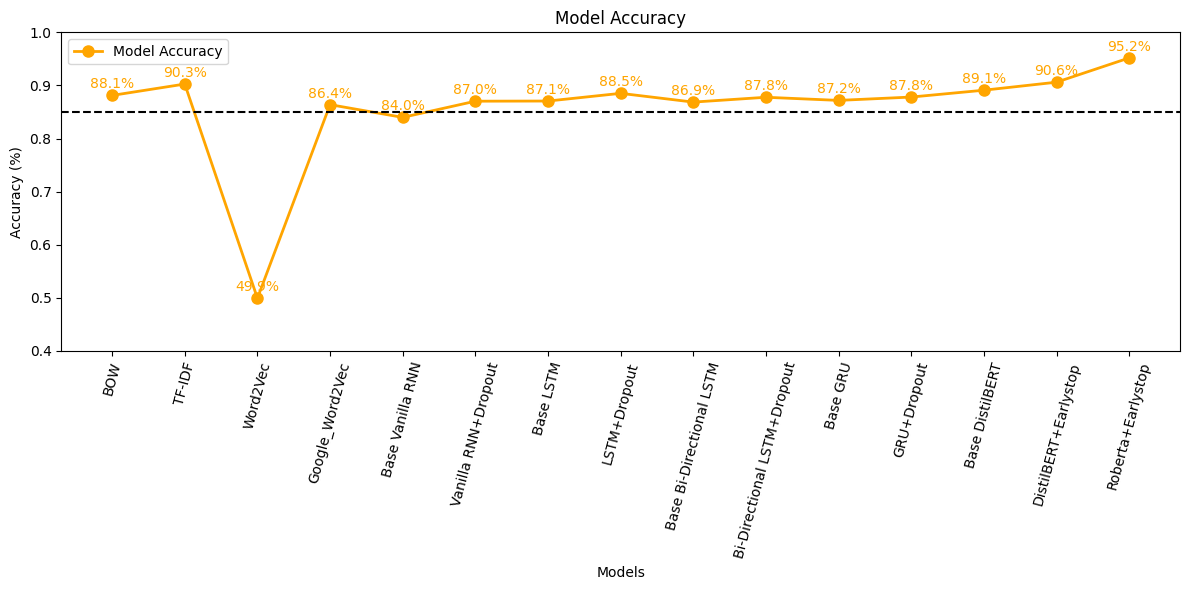

In [73]:
# Plot the data
plt.figure(figsize=(12, 6))

# Plotting Accuracy for each model
plt.plot(df_merged['Model'], df_merged['Accuracy'], marker='o', color='orange', label='Model Accuracy', linewidth=2, markersize=8)

# Adding text annotations for accuracy points
for i, txt in enumerate(df_merged['Accuracy']):
    plt.annotate(f'{txt:.1%}', (df_merged['Model'][i], df_merged['Accuracy'][i]),
                 textcoords="offset points", xytext=(0, 5), ha='center', color='orange')

# Customizing the plot
plt.axhline(y=0.85, color='black', linestyle='--', label='_nolegend_')  # Black dashed line at 85%

# Title and labels
plt.title('Model Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')

# Set the x-axis tick labels to be rotated
plt.xticks(rotation=75)
plt.ylim(0.4, 1.0)

# Display the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Conclusion

Among all models, `transformer-based architectures (DistilBERT and RoBERTa)` outperformed traditional machine learning techniques (SVM with BOW/TF-IDF/Word2Vec) and recurrent neural networks (RNN, LSTM, GRU). **RoBERTa**, with an **accuracy** of **95.2%**, showed the best performance, demonstrating the superiority of transformer models for text classification tasks.

Additionally, normalizing the dataset before preprocessing helped improve accuracy for all models by **0.5 to 1.5 pp**, highlighting the crucial role of data preprocessing in NLP tasks. This improvement emphasizes the importance of clean and consistent data when dealing with text-based models, ensuring that the models can better capture underlying patterns and relationships in the data.